In [1]:
#importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf



In [40]:
#reading the csv file into pandas data frame
data = pd.read_csv("/work/DSCI400-Project/src/cached_data/norm_ALL_DB_COL_data_100_threshold.csv")

def get_idx(target_ind, data):
    '''
    target_ind: target indicator (string)
    data: dataframe of indicators (pandas dataframe)
    '''
    rows = data.shape[0]
    for i in range(rows):
        if data['True'][i] == target_ind:
            return i
    return 0

print(get_idx("NY.GDP.MKTP.KD", data))
#print(data['True'][102])
#print(data)


transpose_data.index

#print(transpose_data.shape)

102


NameError: name 'transpose_data' is not defined

In [48]:
def plot_target_indicator(target_idx, target_ind, data):
    '''
    Plots 2D graph of the target indicator. X value is year, Y value is target indicator value at that year.
    target_ind: string
    data: Pandas dataframe

    returns: Plots of target indicator
    '''
    #plotting the line graph of target indicator

    data.iloc[:, target_idx].plot(figsize=(25,10))
    
    plot_acf(data.iloc[:,target_idx]) #get row 104 instead
    plt.title(target_ind)

    plt.show()


In [51]:
def split_data(dataset, target_idx, training_data_proportion):
    '''
    Splits a dataframe into training and test data

    dataset: Pandas dataframe
    training_data_proportion: float

    Returns: Dataset split into training and test data
    '''    
    #divide the data into train and test data
    train_size = int(len(dataset) * training_data_proportion)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    #index the data into dependent and independent variables
    train_X, train_y = np.concatenate((train[:, :target_idx], train[:,target_idx + 1:]), axis = 1), train[:, target_idx]
    test_X, test_y = np.concatenate((test[:, :target_idx], test[:,target_idx + 1:]), axis = 1), test[:, target_idx]


    # Convert data into suitable dimension for using it as input in LSTM network
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y

In [59]:
#setting the Date column as the index of the data frame
'''
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)

#selecting only those rows, which has City as 'Delhi'
df = data.loc[data['City']=='Delhi']
'''

def LSTM_predictions(target_ind, data, epochs=200, batch_size=72):
    '''
    Get LSTM predictions for target indicator
    
    s: target indicator (string)
    data: dataframe of indicators (pandas dataframe)
    epochs: number of training epochs (int)
    batch_size: how much data in each batch (int)
    
    Returns: Future predicted values of target indicator from LSTM model
    '''
    # Preprocess
    target_idx = get_idx(target_ind, data)
    data = data.drop(['True'], axis=1) #remove indicator names
    transpose_data = data.transpose()
    df = transpose_data
    #df.describe()
    
    # We will use it further to show the graph of multi step prediction
    df_train = df.iloc[0:int(0.8*transpose_data.shape[0])] #select first 80% of the rows (years)
    df_test = df.iloc[int(0.8*transpose_data.shape[0]):] #select latter 20% of the rows (years)

    # plotting the line graph of target indicator and ACF graph
    plot_target_indicator(target_idx, target_ind, df)

    # Scale the values
    dataset = transpose_data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split data into training and test data
    train_X, train_y, test_X, test_y = split_data(dataset, target_idx ,0.8);

    # Train the model
    model = Sequential()
    model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # Prediction on training and testing data
    train_predict = model.predict(train_X)    
    test_predict = model.predict(test_X)       

    # Converting from three dimension to two dimension
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    inv_train_predict = concatenate((train_predict, train_X), axis=1)
    inv_test_predict = concatenate((test_predict, test_X), axis=1)

    # Transforming to original scale
    inv_train_predict = scaler.inverse_transform(inv_train_predict)
    inv_test_predict = scaler.inverse_transform(inv_test_predict)

    # Predicted values on training data
    inv_train_predict = inv_train_predict[:,0]

    # Predicted values on testing data
    inv_test_predict = inv_test_predict[:,0]

    # Scaling back the original train labels
    train_y = train_y.reshape((len(train_y), 1))
    inv_train_y = concatenate((train_y, train_X), axis=1)
    inv_train_y = scaler.inverse_transform(inv_train_y)
    inv_train_y = inv_train_y[:,0]

    # Scaling back the original test labels
    test_y = test_y.reshape((len(test_y), 1))
    inv_test_y = concatenate((test_y, test_X), axis=1)
    inv_test_y = scaler.inverse_transform(inv_test_y)
    inv_test_y = inv_test_y[:,0]

    # Calculating rmse on train data
    rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
    print('Train RMSE: %.3f' % rmse_train)

    # Calculating rmse on test data
    rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
    print('Test RMSE: %.3f' % rmse_test)

    # Plotting the graph of test actual vs predicted
    inv_test_y = inv_test_y.reshape(-1,1)
    inv_test_y.shape

    t = np.arange(0,int(0.2*transpose_data.shape[0])+1,1)

    plt.plot(t,inv_test_y,label='actual')
    plt.plot(t,inv_test_predict,'r',label="predicted")
    plt.title("Actual vs. Predicted Values")
    plt.show()

    # Plotting the graph to show multi step prediction
    plt.figure(figsize=(25, 10))
    plt.plot(df_train.index, inv_train_predict,label="training_set_actual")
    plt.plot(df_test.index, inv_test_predict, color='r',label="test_set_predicted")
    plt.legend(loc='best', fontsize='xx-large')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=16)
    plt.title("Actual Training Set Values vs. Predicted Test Set Values")
    plt.tight_layout()
    plt.show()

    return inv_test_predict

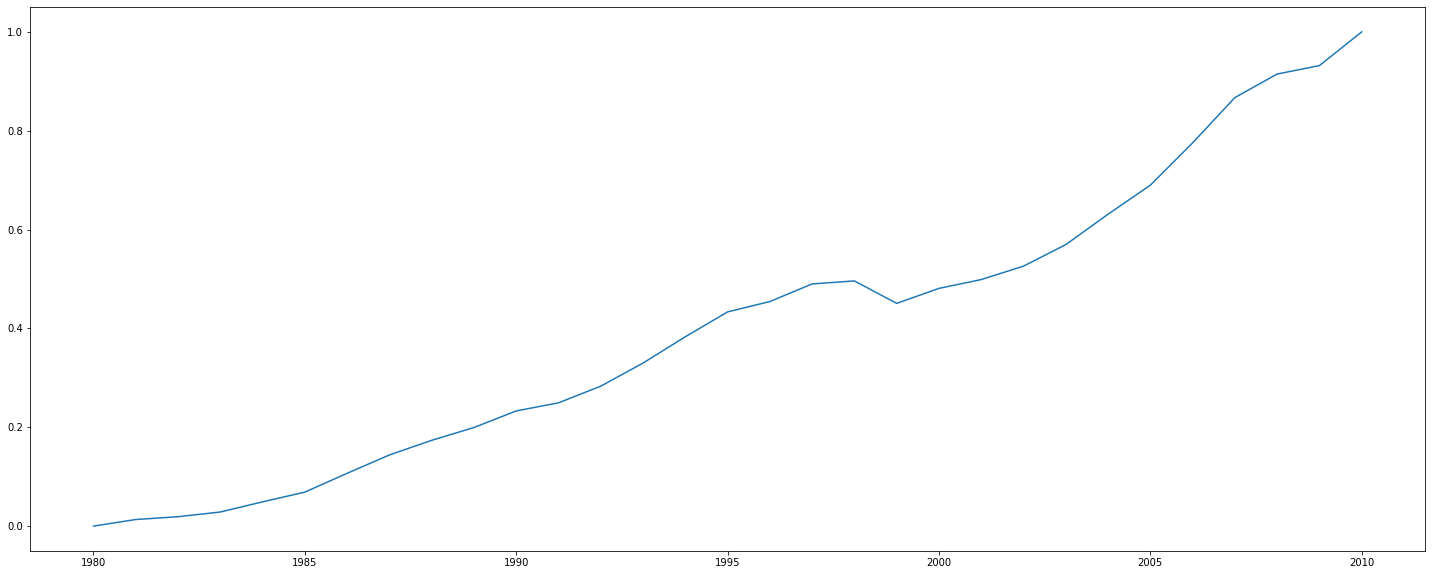

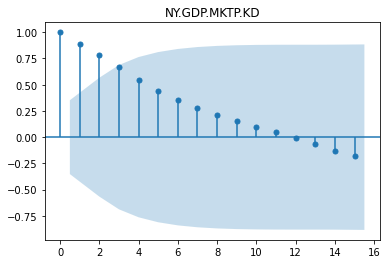

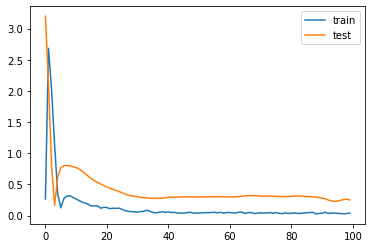

Train RMSE: 0.023
Test RMSE: 0.276


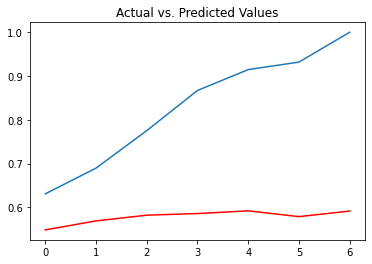

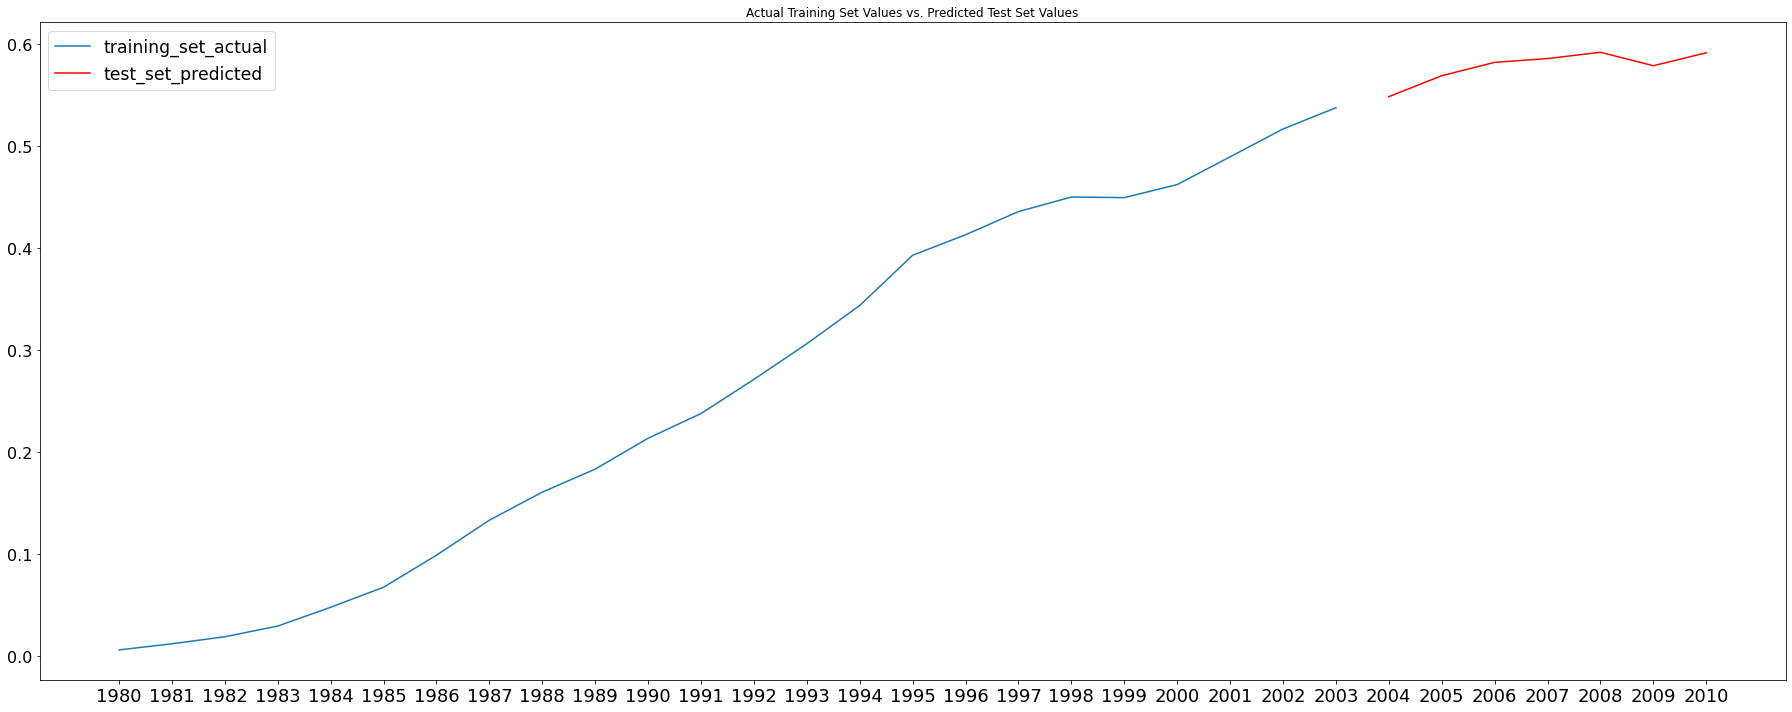

array([0.54873502, 0.56930143, 0.58239031, 0.58610803, 0.59226739,
       0.57908535, 0.59178406])

In [61]:
LSTM_predictions("NY.GDP.MKTP.KD", data, epochs=10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3f7e7e5c-b616-46b2-8e43-ec0d98439404' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>